# In this notebook, we validate the chosen sentiment model using labelled twitter data from Sentiment140

## [Data link](http://help.sentiment140.com/for-students)

---

In [2]:
import warnings
import numpy as np

warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from process_text import sentiment_model
from process_text import clean_up_text
from process_text import preprocess
from process_text import string_cohesion

# The amount of tweets to be used for the model validation
N_subset = 20000

# Specify the name of the file, along with the name of the columns
file_name = './sentiment140/training.1600000.processed.noemoticon.csv'
cols = ['sentiment','id','date','query_string','user','text']

# Read in the data, randomly shuffle and reset the index
df=pd.read_csv(file_name,header=None, names=cols,encoding = "ISO-8859-1")
df=df.sample(frac=1)
df=df.reset_index(drop=True)

# Take a subset of the data for faster evaluation
df = df[0:N_subset]

print(df.head())

   sentiment          id                          date query_string  \
0          4  1932592988  Tue May 26 21:47:19 PDT 2009     NO_QUERY   
1          0  2235570043  Fri Jun 19 01:31:54 PDT 2009     NO_QUERY   
2          4  1760245856  Sun May 10 21:01:37 PDT 2009     NO_QUERY   
3          0  2188530715  Mon Jun 15 22:04:08 PDT 2009     NO_QUERY   
4          4  1971874047  Sat May 30 08:05:04 PDT 2009     NO_QUERY   

            user                                               text  
0       lisalent  @transcribe i dont pull legs.. I mean it, you ...  
1       urbanfly  @katehughes Quite limited as I'm sat at my des...  
2       JCK4life                                   less than three   
3  JeremyShields                        It is so hot in this cafe!   
4     joh_mcgirl  @tommcfly TOOOOM  follow me! Pleasee, hahahaha ;P  


---
# Next, we process all of the tweets using the custom function that we used to train our models
---

In [3]:
df['text']= df['text'].apply(clean_up_text)

---
# Next, we examine the histogram of sentiments

The sentiment140 data uses the following conventions:  
0 $\rightarrow$ -1   
4 $\rightarrow$ +1   


---



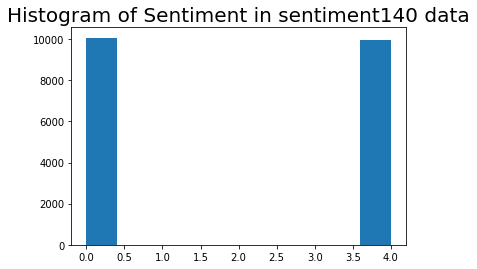

In [5]:
# take all sentiments from the data
y = df['sentiment']

# make the plots
plt.title("Histogram of Sentiment in sentiment140 data", size=20)
plt.hist(y)
plt.show()

---
# Load in the trained sentiment models 
---

In [7]:
# Load in the sentiment models 

import warnings
warnings.filterwarnings('ignore')

from process_text import clean_up_text
from process_text import string_cohesion
from textblob import TextBlob
import spacy
import pickle
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

#--------------------------------------------------------------
# Import the custom stop words
custom_stop_words = []
with open( "stopwords.txt", "r" ) as fin:
    for line in fin.readlines():
        custom_stop_words.append( line.strip() )
#--------------------------------------------------------------


#--------------------------------------------------------------
# Import the vocabulary and generate the vectorizer transformer
#--------------------------------------------------------------
(A,terms,dict_sample) = joblib.load( "/home/javier/Documents/sentiment_analysis/sentiment_model/articles-raw.pkl" )
print( "Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )
print('number of terms: ',len(terms))#print(dic_sample[0:10])
print('Dictionary: ',len(dict_sample))

vectorizer = TfidfVectorizer(stop_words = custom_stop_words,min_df = 20)
A = vectorizer.fit_transform(dict_sample)
print('A: ', A.shape)
#--------------------------------------------------------------


#--------------------------------------------------------------
# We load the trained models
#--------------------------------------------------------------
# The names of the files containing the weights of the model
filename1 = 'lr_sentiment_model.sav'
filename2 = 'nb_sentiment_model.sav'

# Now we load in the trained models
loaded_lr = pickle.load(open(filename1, 'rb'))
loaded_nb = pickle.load(open(filename2, 'rb'))

Loaded 3500 X 2443 document-term matrix
number of terms:  2443
Dictionary:  8750
A:  (8750, 2443)


---
# Now we compute the accuracy, recall and f1 score of the model using the loaded tweets for different thresholds
---

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from tqdm import tqdm


threshold = [0.2,0.4,0.6,0.8]
model_accuracy = []
model_sample_size = []
model_recall=[]
model_f1=[]


for t in threshold:
    
    sentiment_pred = []
    sentiment_prob = []
    y = []
    
    for k in tqdm(range(0,len(df))):
        # The Tweet to be analysed
        sample_text = df['text'][k]

        # The labelled sentiment of the tweet
        true_sentiment = df['sentiment'][k]

        # We map the sentiment to our values
        if(true_sentiment==0):
            y_true = -1
        elif(true_sentiment==4):
            y_true = +1

        pred,prob = sentiment_model(sample_text,t,vectorizer, loaded_lr,loaded_nb)
        
        
        # We look only at non-neutral sentiment predictions
        if(pred!=0):
            y.append(y_true)
            sentiment_pred.append(pred)
            sentiment_prob.append(prob)
    
    # Compute the accuracy and the recall of the models
    acc = accuracy_score(y_pred=sentiment_pred,y_true=y) 
    rec = recall_score(y_pred=sentiment_pred, y_true=y)
    f1 = f1_score(y_pred=sentiment_pred, y_true=y)
    
    model_accuracy.append(rec)
    model_recall.append(acc)
    model_f1.append(f1)
    model_sample_size.append(len(y))

100%|██████████| 20000/20000 [02:24<00:00, 138.57it/s]


# Now that the model has been loaded, we will plot the model metrics

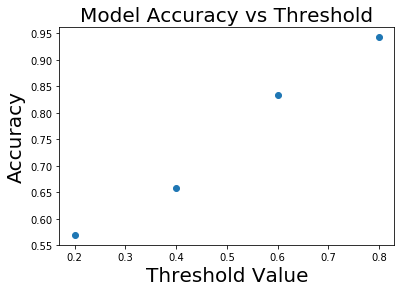

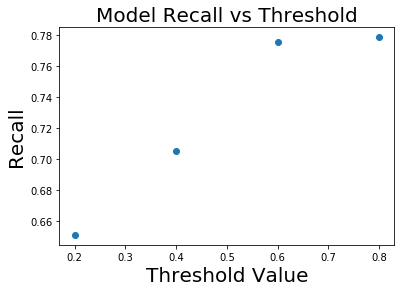

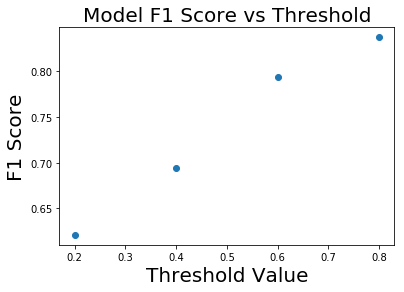

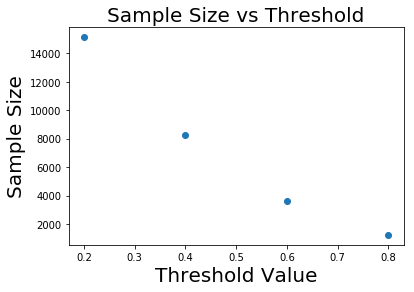

In [24]:
plt.plot(threshold,model_accuracy,'o')
plt.title('Model Accuracy vs Threshold',size=20)
plt.ylabel('Accuracy',size=20)
plt.xlabel('Threshold Value',size=20)
plt.show()

plt.plot(threshold,model_recall,'o')
plt.title('Model Recall vs Threshold',size=20)
plt.ylabel('Recall',size=20)
plt.xlabel('Threshold Value',size=20)
plt.show()

plt.plot(threshold,model_f1,'o')
plt.title('Model F1 Score vs Threshold',size=20)
plt.ylabel('F1 Score',size=20)
plt.xlabel('Threshold Value',size=20)
plt.show()


plt.plot(threshold,model_sample_size,'o')
plt.title('Sample Size vs Threshold',size=20)
plt.ylabel('Sample Size',size=20)
plt.xlabel('Threshold Value',size=20)
plt.show()

# Choosing a threshold of $T=0.6$ appears to be a reasonable value to use